# Nonzero Drift

## With zero variance, $G \propto \mu$

### 1.) $G_0(\mu, \gamma) = G(\mu, 0, \gamma) =  \begin{cases}
    \frac{\mu}{\gamma+1} & \mu \geq 0\\
    \frac{\mu}{\frac{1}{\gamma}+1} & \mu < 0
  \end{cases}
$

If $\sigma = 0$, then we know $S(t) = e^{\mu t}$.

If $\mu \geq 0$, then $m_p$ is growing, so $m_u < m_p$, and in particular $\frac{R_\beta}{R_\alpha} = m_u = \gamma m_p = \gamma e^{\mu t} \iff R_\beta = R_\alpha \gamma e^{\mu t}$

WLOG, assuming we started with $R_\alpha = R_\beta = 1$, we know from path independence (since we've only ever traded in one direction) that $R_\alpha R_\beta^\gamma = 1 \iff R_\alpha = R_\beta^{-\gamma}$

Substituting this into the prior result, we end up with

$R_\beta = R_\beta^{-\gamma} \gamma e^{\mu t} \iff R_\beta = (\gamma e^{\mu t})^{\frac{1}{1 + \gamma}}$

Then $W = e^{\mu t}R_\alpha + R_\beta = \frac{\gamma +1}{\gamma}R_\beta = \frac{\gamma +1}{\gamma}(\gamma e^{\mu t})^{\frac{1}{1 + \gamma}}$

So $\log W = \log{\frac{\gamma +1}{\gamma}} + \log{(\gamma e^{\mu t})^{\frac{1}{1 + \gamma}}}
= \log{\frac{\gamma +1}{\gamma}} + \frac{1}{1 + \gamma}(\log{\gamma} + \mu t)$ 

and $G = \mathop{\mathbb{E}}[\displaystyle{\lim_{T\to\inf}}\frac{1}{T}\log(W(T))] = \frac{\mu}{\gamma + 1}$

By symmetry, this is $\frac{\mu}{\frac{1}{\gamma}+1}$ when $\mu < 0$

In [1]:
import torch
import numpy as np
import scipy.stats
import lp_wealth
from sim_helpers import *
from notebook_helpers import *

1 0.0020852088928222656
101 0.12541866302490234
201 0.1322007179260254
301 0.12319326400756836
401 0.11987066268920898
501 0.1204831600189209
601 0.12650299072265625
701 0.12337231636047363
801 0.12436413764953613
901 0.12001609802246094


[Text(0, 0.5, 'G'), Text(0.5, 0, 'pred')]

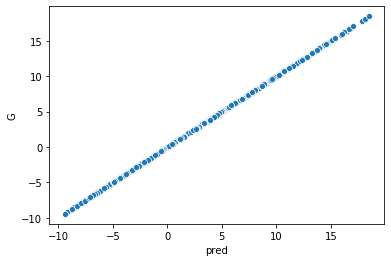

In [2]:
num_samples = 1000

sigma = torch.tensor(0.)
mu = 40 * (torch.rand(num_samples) - .5)
gamma = torch.rand(num_samples) * .9 + 0.05

time_step = torch.tensor(0.1)
num_steps = 1000

sim = lp_wealth.Sim(mu, sigma, gamma, time_step, num_samples, cuda=True)

sim_loop(sim, num_steps)

pred = np.where(mu >0, mu / (gamma + 1), mu/(1/gamma +1))
ax = sbn.scatterplot(pred, sim.compute_wealth_growth_rate())
ax.set(xlabel='pred', ylabel='G')

## However, with nonzero variance, the relationship becomes nonlinear

In particular, let $\mu' = \mu - \frac{\sigma^2}{2}$ be the true drift of $\log m_p$.

$G(\mu, \sigma, \gamma) = G_0(\mu', \gamma) + D(\mu', \sigma, \gamma)$

where

$D(0, \sigma, \gamma) = G(\frac{\sigma^2}{2}, \sigma, \gamma)$

and

$\displaystyle{\lim_{\lvert \mu' \rvert \to \infty}}D(\mu', \sigma, \gamma) = 0$

1 0.0014858245849609375
1326 1.6205573081970215
2651 1.6569414138793945
3976 1.6343822479248047
5301 1.611694574356079
6626 1.5532433986663818
7951 1.6328620910644531
9276 1.5499682426452637
10601 1.5492336750030518
11926 1.5435352325439453
13251 1.5471317768096924


[Text(0, 0.5, 'D'), Text(0.5, 0, "$\\mu$'")]

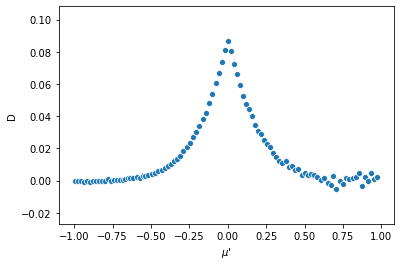

In [42]:
num_samples = 10000

sigma = torch.tensor(1.)
mu = sigma**2 / 2 + (torch.rand(num_samples) - .5) * 2
gamma = torch.tensor(0.1)

time_step = get_max_time_step(gamma, sigma, mu)
num_steps = get_min_time_steps(sigma, gamma, time_step)

sim = lp_wealth.Sim(mu, sigma, gamma, time_step, num_samples, cuda=True)

sim_loop(sim, num_steps)

adj_mu = mu-sigma**2/2
pred = np.where(adj_mu >0, adj_mu / (gamma + 1), adj_mu/(1/gamma +1))
d = sim.compute_wealth_growth_rate()-pred
ax = bin_plot(adj_mu, d)
ax.set(xlabel="$\mu$'", ylabel='D')

## D is symmetrical around 0

It appears empirically that 

$D(\mu', \sigma, \gamma) = D(-\mu', \sigma, \gamma)$

We can also see that there is less simulation variance when $\mu' < 0$, presumably because a negative $\mu'$ shrinks $m_p$ and thus leads to a smaller multiple in $m_p R_\alpha + R_\beta$

[Text(0, 0.5, 'D'), Text(0.5, 0, "|$\\mu$'|")]

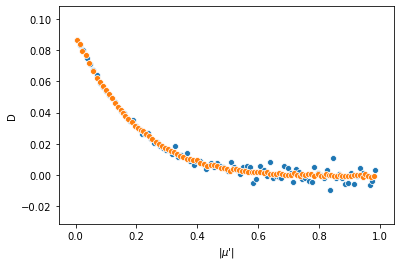

In [40]:
pos = adj_mu > 0 
ax = bin_plot(adj_mu[pos], d[pos])
ax = bin_plot(np.abs(adj_mu[~pos]), d[~pos])
ax.set(xlabel="|$\mu$'|", ylabel='D')

## Why $\displaystyle{\lim_{\lvert \mu' \rvert \to \infty}}D(\mu', \sigma, \gamma) = 0$

Now, why should we have $\displaystyle{\lim_{\lvert \mu' \rvert \to \infty}}D(\mu', \sigma, \gamma) = 0 \iff \displaystyle{\lim_{\lvert \mu \rvert \to \infty}} G(\mu, \sigma, \gamma) = G_0(\mu', \gamma)$ ?

Well, let's consider the case where we have $\sigma = 1, \mu = \frac{1}{2}, \gamma = e^{-.5} \iff \log{\gamma} = -.5$.

Let's consider the path for $m_p$ where $\log{m_p}(t) = \begin{cases}
    -t & 0 \leq t \leq 1\\
    t -2 & t > 1
  \end{cases}$ 

This path dips down to -1 at a constant rate, triggering a trade to the downside because $-1 < -.5$, before reversing course and trading to the upside.

However, if we were to change $\mu$ from $\frac{1}{2}$ to $\frac{3}{2}$, then this path would be transformed as follows:

$\log{m_p'}(t) = \begin{cases}
    0 & 0 \leq t \leq 1\\
    2t-2 & t > 1
  \end{cases}$ 
  
In this case, $\log{m_p'}$ only ever increases, so that there are never any trades to the downside.

Now, the wealth growth due to $\sigma$ is entirely due to back-and-forth trades, and as we increase $\mu$, more and more back-and-forth trades get canceled out by this type of effect.

When we simulate dropping $\mu$, we can indeed see that eventually $m_u$ is never too low -- i.e. there are never any trades to the upside.




1 0.00286865234375
1326 1.663243293762207
2651 1.658015489578247
3976 1.6850826740264893
5301 1.6090667247772217
6626 1.6078076362609863
7951 1.6533668041229248
9276 1.6505324840545654
10601 1.6352698802947998
11926 1.601532220840454
13251 1.6040387153625488


[Text(0, 0.5, 'too low updates'), Text(0.5, 0, "$\\mu$'")]

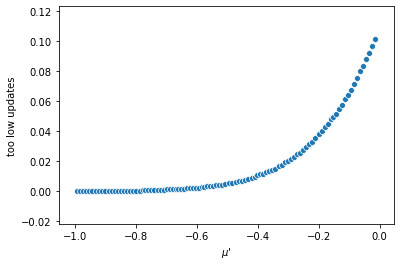

In [201]:
num_samples = 10000

sigma = torch.tensor(1.)
mu = sigma**2 / 2 + (torch.rand(num_samples)) * - 1
gamma = torch.tensor(0.1)

time_step = get_max_time_step(gamma, sigma, mu)
num_steps = get_min_time_steps(sigma, gamma, time_step)

sim = lp_wealth.Sim(mu, sigma, gamma, time_step, num_samples, cuda=True)

sim_loop(sim, num_steps)

adj_mu = mu-sigma**2/2
pred = np.where(adj_mu >0, adj_mu / (gamma + 1), adj_mu/(1/gamma +1))
d = sim.compute_wealth_growth_rate()-pred
ax = bin_plot(adj_mu, (torch.abs(sim.log_r_alpha_low_updates) + torch.abs(sim.log_r_beta_low_updates)).cpu()/sim.compute_elapsed_time())
ax.set(xlabel="$\mu$'", ylabel='too low updates')